In [1]:
import time
import xgboost as xgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from __future__ import division

from subprocess import check_output
print(check_output(["ls", "input/"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
prediction_lgbm.pkl
products.csv
sample_submission.csv



/Users/shaolongchen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns',60)

In [3]:
def load_data(path_data):
    '''
    --------------------------------order_product--------------------------------
    * Unique in order_id + product_id
    '''
    priors = pd.read_csv(path_data + 'order_products__prior.csv', 
                     dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    train = pd.read_csv(path_data + 'order_products__train.csv', 
                    dtype={
                            'order_id': np.int32,
                            'product_id': np.uint16,
                            'add_to_cart_order': np.int16,
                            'reordered': np.int8})
    '''
    --------------------------------order--------------------------------
    * This file tells us which set (prior, train, test) an order belongs
    * Unique in order_id
    * order_id in train, prior, test has no intersection
    * this is the #order_number order of this user
    '''
    orders = pd.read_csv(path_data + 'orders.csv', 
                         dtype={
                                'order_id': np.int32,
                                'user_id': np.int64,
                                'eval_set': 'category',
                                'order_number': np.int16,
                                'order_dow': np.int8,
                                'order_hour_of_day': np.int8,
                                'days_since_prior_order': np.float32})

    #  order in prior, train, test has no duplicate
    #  order_ids_pri = priors.order_id.unique()
    #  order_ids_trn = train.order_id.unique()
    #  order_ids_tst = orders[orders.eval_set == 'test']['order_id'].unique()
    #  print(set(order_ids_pri).intersection(set(order_ids_trn)))
    #  print(set(order_ids_pri).intersection(set(order_ids_tst)))
    #  print(set(order_ids_trn).intersection(set(order_ids_tst)))

    '''
    --------------------------------product--------------------------------
    * Unique in product_id
    '''
    products = pd.read_csv(path_data + 'products.csv')
    aisles = pd.read_csv(path_data + "aisles.csv")
    departments = pd.read_csv(path_data + "departments.csv")
    sample_submission = pd.read_csv(path_data + "sample_submission.csv")
    
    return priors, train, orders, products, aisles, departments, sample_submission

class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))
            
def ka_add_groupby_features_1_vs_n(df, group_columns_list, agg_dict, only_new_feature=True):
    '''Create statistical columns, group by [N columns] and compute stats on [N column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       agg_dict: python dictionary

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       {real_column_name: {your_specified_new_column_name : method}}
       agg_dict = {'user_id':{'prod_tot_cnts':'count'},
                   'reordered':{'reorder_tot_cnts_of_this_prod':'sum'},
                   'user_buy_product_times': {'prod_order_once':lambda x: sum(x==1),
                                              'prod_order_more_than_once':lambda x: sum(x==2)}}
       ka_add_stats_features_1_vs_n(train, ['product_id'], agg_dict)
    '''
    with tick_tock("add stats features"):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')

    return df_new

def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

print 'done'

done


In [4]:
path_data = '/Users/shaolongchen/Data Science/Kaggle/Instacart/input/'
priors, train, orders, products, aisles, departments, sample_submission = load_data(path_data)
print 'loading data done'

loading data done


In [5]:
print 'aisles.shape (%s, %s)' % aisles.shape
print 'departments.shape  (%s, %s)' % departments.shape
print 'sample_submission.shape  (%s, %s)' % sample_submission.shape
print 'products.shape  (%s, %s)' % products.shape
print 'priors.shape  (%s, %s)' % priors.shape
print 'train.shape  (%s, %s)' % train.shape

aisles.shape (134, 2)
departments.shape  (21, 2)
sample_submission.shape  (75000, 2)
products.shape  (49688, 4)
priors.shape  (32434489, 4)
train.shape  (1384617, 4)


# Product

In [6]:
fruit_dict = {}
for name in aisles.aisle.tolist():
    if name.find('fruits')!=-1:
        fruit_dict[name] = aisles[aisles.aisle==name]['aisle_id'].values[0]
        
vegetable_dict = {}
for name in aisles.aisle.tolist():
    if name.find('vegetables')!=-1:
        vegetable_dict[name] = aisles[aisles.aisle==name]['aisle_id'].values[0]
        
print 'done'

done


In [7]:
product = products.copy()
product['Organic'] = [1 if name.find('Organic')!=-1 else 0 for name in product.product_name.values]
product['fruit'] = [1 if aisle_id in fruit_dict.values() else 0 for aisle_id in product.aisle_id.values]
product['vegetable'] = [1 if aisle_id in vegetable_dict.values() else 0 for aisle_id in product.aisle_id.values]

print 'done'

done


In [8]:
prd0 = product.drop('product_name', axis=1, inplace=False)
print prd0.shape
prd0.head()

(49688, 6)


,product_id,aisle_id,department_id,Organic,fruit,vegetable
0,1,61,19,0,0,0
1,2,104,13,0,0,0
2,3,94,7,0,0,0
3,4,38,1,0,0,0
4,5,5,13,0,0,0


In [9]:
# Products information ----------------------------------------------------------------
# add order information to priors set
priors_orders_detail = orders.merge(right=priors, how='inner', on='order_id')

# create new variables
# _user_buy_product_times: 用户是第几次购买该商品
priors_orders_detail.loc[:,'_user_buy_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount() + 1
# _prod_tot_cnts: 该商品被购买的总次数,表明被喜欢的程度
# _reorder_tot_cnts_of_this_prod: 这件商品被再次购买的总次数
### 我觉得下面两个很不好理解，考虑改变++++++++++++++++++++++++++
# _prod_order_once: 该商品被购买一次的总次数
# _prod_order_more_than_once: 该商品被购买一次以上的总次数
agg_dict = {'user_id':{'_prod_tot_cnts':'count'}, 
            'reordered':{'_prod_reorder_tot_cnts':'sum'}, 
            'add_to_cart_order':{'product_add_average_cart_position': 'mean'},
            '_user_buy_product_times': {'_prod_buy_first_time_total_cnt':lambda x: sum(x==1),
                                        '_prod_buy_second_time_total_cnt':lambda x: sum(x==2)}}
prd = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['product_id'], agg_dict)

# _prod_reorder_prob: 这个指标不好理解
# _prod_reorder_ratio: 商品复购率
prd['_prod_reorder_prob'] = prd._prod_buy_second_time_total_cnt / prd._prod_buy_first_time_total_cnt
prd['_prod_reorder_ratio'] = prd._prod_reorder_tot_cnts / prd._prod_tot_cnts
prd['_prod_reorder_times'] = 1 + prd._prod_reorder_tot_cnts / prd._prod_buy_first_time_total_cnt

print prd.shape
prd.head()

add stats features begin ......


/Users/shaolongchen/anaconda/lib/python2.7/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


add stats features end ......
time lapsing 197.301020145 s 

(49677, 9)


,product_id,product_add_average_cart_position,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,5.801836,276,716,1852,1136.0,0.385475,0.613391,2.586592
1,2,9.888889,8,78,90,12.0,0.102564,0.133333,1.153846
2,3,6.415162,36,74,277,203.0,0.486486,0.732852,3.743243
3,4,9.507599,64,182,329,147.0,0.351648,0.446809,1.807692
4,5,6.466667,4,6,15,9.0,0.666667,0.600000,2.500000


In [10]:
prd = pd.merge(prd0, prd, on='product_id', how='inner')
print prd.shape
prd.head()

(49677, 14)


,product_id,aisle_id,department_id,Organic,fruit,vegetable,product_add_average_cart_position,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,61,19,0,0,0,5.801836,276,716,1852,1136.0,0.385475,0.613391,2.586592
1,2,104,13,0,0,0,9.888889,8,78,90,12.0,0.102564,0.133333,1.153846
2,3,94,7,0,0,0,6.415162,36,74,277,203.0,0.486486,0.732852,3.743243
3,4,38,1,0,0,0,9.507599,64,182,329,147.0,0.351648,0.446809,1.807692
4,5,5,13,0,0,0,6.466667,4,6,15,9.0,0.666667,0.600000,2.500000


# User

In [11]:
# _user_total_orders: 用户的总订单数
# 可以考虑加入其它统计指标++++++++++++++++++++++++++
# _user_sum_days_since_prior_order: 距离上次购买时间(和),这个只能在orders表里面计算，priors_orders_detail不是在order level上面unique
# _user_mean_days_since_prior_order: 距离上次购买时间(均值)
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
              'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                        '_user_mean_days_since_prior_order': 'mean'}}
users = ka_add_groupby_features_1_vs_n(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)
print users.shape
users.head()

add stats features begin ......
add stats features end ......
time lapsing 0.391793966293 s 

(206209, 4)


,user_id,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders
0,1,19.555555,176.0,10
1,2,15.230769,198.0,14
2,3,12.090909,133.0,12
3,4,13.750000,55.0,5
4,5,13.333333,40.0,4


In [12]:
# _user_reorder_ratio: reorder的总次数 / 第一单后买后的总次数
# _user_total_products: 用户购买的总商品数
# _user_distinct_products: 用户购买的unique商品数
agg_dict_3 = {'reordered':
              {'_user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.loc[x.index,'reordered']==1)/
                         sum(priors_orders_detail.loc[x.index,'order_number'] > 1)},
              'product_id':{'_user_total_products':'count', 
                            '_user_distinct_products': lambda x: x.nunique()}}
us = ka_add_groupby_features_1_vs_n(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')
print users.shape
users.head()

add stats features begin ......
add stats features end ......
time lapsing 527.368573904 s 

(206209, 7)


,user_id,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio
0,1,19.555555,176.0,10,59,18,0.759259
1,2,15.230769,198.0,14,195,102,0.510989
2,3,12.090909,133.0,12,88,33,0.705128
3,4,13.750000,55.0,5,18,17,0.071429
4,5,13.333333,40.0,4,37,23,0.538462


In [13]:
def add_groupby_features(df, group_cols, agg_dict):
#    print "grouping in process..."
    grouped = df.groupby(group_cols).agg(agg_dict)
    grouped.columns = grouped.columns.droplevel(0)
    grouped.reset_index(inplace=True)
#    print "group done."
    return grouped

In [14]:
agg_dict5 = {'product_id':{'each_order_cnts':'count'}}
user_temp = add_groupby_features(priors_orders_detail,["order_id"],agg_dict5)
user_temp = user_temp.merge(right=orders[orders.eval_set=="prior"][["order_id","user_id"]],how="left",on="order_id")
print user_temp.shape
user_temp.head()

(3214874, 3)


,order_id,each_order_cnts,user_id
0,2,9,202279
1,3,8,205970
2,4,13,178520
3,5,26,156122
4,6,3,22352


In [15]:
agg_dict6 = {'each_order_cnts':{'_user_median_basket':'median',
                                 '_user_min_basket':'min', 
                                 "_user_max_basket":'max', }}
user_temp = add_groupby_features(user_temp,["user_id"],agg_dict6)
print user_temp.shape
user_temp.head()

'agg_dict6 = {\'each_order_cnts\':{\'_user_mean_basket\':\'mean\',\n                                 \'_user_median_basket\':\'median\',\n                                 \'_user_min_basket\':\'min\', \n                                 "_user_max_basket":\'max\', }}\nuser_temp = add_groupby_features(user_temp,["user_id"],agg_dict6)\nprint user_temp.shape\nuser_temp.head()'

In [16]:
'''agg_dict7 = {'order_dow':{'_user_average_dow':'mean', '_user_frequent_dow':lambda x: x.value_counts().idxmax()}, 
            'order_hour_of_day':{'_user_average_hour':'mean', '_user_frequent_hour':lambda x: x.value_counts().idxmax()}} 

user_temp = add_groupby_features(priors_orders_detail, ['user_id'], agg_dict7)
print user_temp.shape
user_temp.head()'''

(206209, 5)


,user_id,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow
0,1,10.542373,7,4,2.644068
1,2,10.441026,9,2,2.005128
2,3,16.352273,16,0,1.011364
3,4,13.111111,15,4,4.722222
4,5,15.729730,18,3,1.621622


In [17]:
users = users.merge(right=user_temp,on="user_id",how="left")
print users.shape
users.head()

(206209, 11)


,user_id,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow
0,1,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068
1,2,15.230769,198.0,14,195,102,0.510989,10.441026,9,2,2.005128
2,3,12.090909,133.0,12,88,33,0.705128,16.352273,16,0,1.011364
3,4,13.750000,55.0,5,18,17,0.071429,13.111111,15,4,4.722222
4,5,13.333333,40.0,4,37,23,0.538462,15.729730,18,3,1.621622


In [18]:
# 平均每单的商品数
# 每单中最多的商品数，最少的商品数++++++++++++++
users['_user_average_basket'] = users._user_total_products / users._user_total_orders

us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')
print users.shape
users.head()

(206209, 15)


,user_id,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_user_average_basket,order_id,eval_set,time_since_last_order
0,1,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.900000,1187899,train,14.0
1,2,15.230769,198.0,14,195,102,0.510989,10.441026,9,2,2.005128,13.928571,1492625,train,30.0
2,3,12.090909,133.0,12,88,33,0.705128,16.352273,16,0,1.011364,7.333333,2774568,test,11.0
3,4,13.750000,55.0,5,18,17,0.071429,13.111111,15,4,4.722222,3.600000,329954,test,30.0
4,5,13.333333,40.0,4,37,23,0.538462,15.729730,18,3,1.621622,9.250000,2196797,train,6.0


In [19]:
# 这里应该还有很多变量可以被添加
# _up_order_count: 用户购买该商品的次数
# _up_first_order_number: 用户第一次购买该商品所处的订单数
# _up_last_order_number: 用户最后一次购买该商品所处的订单数
# _up_average_cart_position: 该商品被添加到购物篮中的平均位置
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
              'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = ka_add_groupby_features_1_vs_n(df=priors_orders_detail, 
                                                      group_columns_list=['user_id', 'product_id'], 
                                                      agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')
# 该商品购买次数 / 总的订单数
# 最近一次购买商品 - 最后一次购买该商品
# 该商品购买次数 / 第一次购买该商品到最后一次购买商品的的订单数
data['_up_order_rate'] = data._up_order_count / data._user_total_orders
data['_up_order_since_last_order'] = data._user_total_orders - data._up_last_order_number
data['_up_order_rate_since_first_order'] = data._up_order_count / (data._user_total_orders - data._up_first_order_number + 1)

# add user_id to train set
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

print data.shape
data.head()

add stats features begin ......
add stats features end ......
time lapsing 28.3228201866 s 

(13307953, 37)


,user_id,product_id,_up_average_cart_position,_up_order_count,_up_first_order_number,_up_last_order_number,aisle_id,department_id,Organic,fruit,vegetable,product_add_average_cart_position,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1,196,1.400000,10,1,10,77,7,0,0,0,3.721774,4660,8000,35791,27791.0,0.582500,0.776480,4.473875,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,1187899,train,14.0,1.0,0,1.000000,1.0
1,1,10258,3.333333,9,2,10,117,19,0,0,0,4.277492,308,557,1946,1389.0,0.552962,0.713772,3.493716,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,1187899,train,14.0,0.9,0,1.000000,1.0
2,1,10326,5.000000,1,5,5,24,4,1,1,0,4.191097,1003,1923,5526,3603.0,0.521581,0.652009,2.873635,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,1187899,train,14.0,0.1,5,0.166667,NaN
3,1,12427,3.300000,10,1,10,23,19,0,0,0,4.760037,889,1679,6476,4797.0,0.529482,0.740735,3.857058,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,1187899,train,14.0,1.0,0,1.000000,NaN
4,1,13032,6.333333,3,2,10,121,14,0,0,0,5.622767,617,1286,3751,2465.0,0.479782,0.657158,2.916796,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,1187899,train,14.0,0.3,0,0.333333,1.0


# XGB train

In [20]:
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)
print train.shape
train.head()

/Users/shaolongchen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(8474661, 33)


/Users/shaolongchen/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,_up_average_cart_position,_up_order_count,_up_first_order_number,_up_last_order_number,aisle_id,department_id,Organic,fruit,vegetable,product_add_average_cart_position,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_user_average_basket,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
0,1.400000,10,1,10,77,7,0,0,0,3.721774,4660,8000,35791,27791.0,0.582500,0.776480,4.473875,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,14.0,1.0,0,1.000000,1.0
1,3.333333,9,2,10,117,19,0,0,0,4.277492,308,557,1946,1389.0,0.552962,0.713772,3.493716,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,14.0,0.9,0,1.000000,1.0
2,5.000000,1,5,5,24,4,1,1,0,4.191097,1003,1923,5526,3603.0,0.521581,0.652009,2.873635,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,14.0,0.1,5,0.166667,0.0
3,3.300000,10,1,10,23,19,0,0,0,4.760037,889,1679,6476,4797.0,0.529482,0.740735,3.857058,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,14.0,1.0,0,1.000000,0.0
4,6.333333,3,2,10,121,14,0,0,0,5.622767,617,1286,3751,2465.0,0.479782,0.657158,2.916796,19.555555,176.0,10,59,18,0.759259,10.542373,7,4,2.644068,5.9,14.0,0.3,0,0.333333,1.0


In [21]:
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

In [22]:
test_size = 0.25
num_boost_round=50

In [23]:
# subsample 让training时间更短

X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered,
                                                    test_size=test_size, random_state=42)
print "splitting done"

d_train = xgb.DMatrix(X_train, y_train)
d_val = xgb.DMatrix(X_val,y_val)
print "DMatrix done"

watchlist= [(d_train, "train"),(d_val,'val')]
model = xgb.train(params=xgb_params, dtrain=d_train, num_boost_round=num_boost_round, early_stopping_rounds=10, evals=watchlist, verbose_eval=1)

model.save_model("model.model")
print 'training is done'

splitting done
DMatrix done
[0]	train-logloss:0.625865	val-logloss:0.625894
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.570899	val-logloss:0.570945
[2]	train-logloss:0.524991	val-logloss:0.525065
[3]	train-logloss:0.486489	val-logloss:0.486588
[4]	train-logloss:0.453884	val-logloss:0.454009
[5]	train-logloss:0.426171	val-logloss:0.42632
[6]	train-logloss:0.402373	val-logloss:0.402537
[7]	train-logloss:0.381901	val-logloss:0.382077
[8]	train-logloss:0.364231	val-logloss:0.364422
[9]	train-logloss:0.348904	val-logloss:0.349111
[10]	train-logloss:0.3357	val-logloss:0.335928
[11]	train-logloss:0.324141	val-logloss:0.32438
[12]	train-logloss:0.314139	val-logloss:0.314394
[13]	train-logloss:0.305374	val-logloss:0.305641
[14]	train-logloss:0.297768	val-logloss:0.298043
[15]	train-logloss:0.291157	val-logloss:0.291438
[16]	train-logloss:0.28537	val-logloss:0.285659
[17]	tr

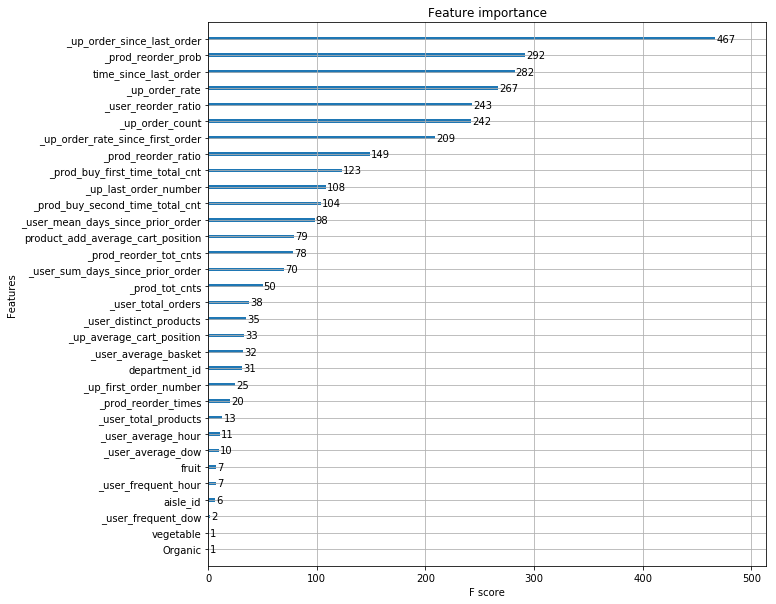

In [24]:
#xgb.plot_importance(bst)

import matplotlib.pyplot as plt
%matplotlib inline

ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

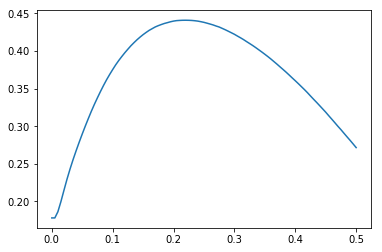

p value for max F1 score: 0.22
Maximum F1 score: 0.440938706


In [25]:
#Find the threshhold p to get best F1-score

from sklearn.metrics import f1_score
p_list = np.linspace(0,0.5,num=101)
score_list = []
for p in p_list:
    score = f1_score(y_true=y_train, y_pred=(model.predict(d_train) > p).astype(int))
    score_list = score_list+[score]
plt.plot(p_list,score_list)
plt.show()
print "p value for max F1 score:", p_list[np.argmax(score_list)]
print "Maximum F1 score:", max(score_list)
best_p = p_list[np.argmax(score_list)]

In [26]:
X_test = data.loc[data.eval_set == "test",:]
d_test = xgb.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))

In [27]:
X_test.loc[:,'reordered'] = (model.predict(d_test) > best_p).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)#to make str joining convenient

In [28]:
print X_test.shape
X_test.head()

(4833292, 37)


,user_id,product_id,_up_average_cart_position,_up_order_count,_up_first_order_number,_up_last_order_number,aisle_id,department_id,Organic,fruit,vegetable,product_add_average_cart_position,_prod_buy_second_time_total_cnt,_prod_buy_first_time_total_cnt,_prod_tot_cnts,_prod_reorder_tot_cnts,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_mean_days_since_prior_order,_user_sum_days_since_prior_order,_user_total_orders,_user_total_products,_user_distinct_products,_user_reorder_ratio,_user_average_hour,_user_frequent_hour,_user_frequent_dow,_user_average_dow,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,reordered
18,15,196,2.200,5,15,22,77,7,0,0,0,3.721774,4660,8000,35791,27791.0,0.582500,0.776480,4.473875,10.809524,227.0,22,72,13,0.867647,11.444444,11,1,2.472222,3.272727,2161313,test,7.0,0.227273,0,0.625000,1
19,15,12427,2.100,10,1,20,23,19,0,0,0,4.760037,889,1679,6476,4797.0,0.529482,0.740735,3.857058,10.809524,227.0,22,72,13,0.867647,11.444444,11,1,2.472222,3.272727,2161313,test,7.0,0.454545,2,0.454545,1
20,15,1747,3.500,4,8,19,23,19,0,0,0,7.901934,221,562,1448,886.0,0.393238,0.611878,2.576512,10.809524,227.0,22,72,13,0.867647,11.444444,11,1,2.472222,3.272727,2161313,test,7.0,0.181818,3,0.266667,0
21,15,10441,2.375,8,1,22,117,19,0,0,0,4.083190,465,867,2909,2042.0,0.536332,0.701959,3.355248,10.809524,227.0,22,72,13,0.867647,11.444444,11,1,2.472222,3.272727,2161313,test,7.0,0.363636,0,0.363636,1
22,15,11266,1.600,10,1,19,117,19,0,0,0,4.667238,645,1081,4081,3000.0,0.596670,0.735114,3.775208,10.809524,227.0,22,72,13,0.867647,11.444444,11,1,2.472222,3.272727,2161313,test,7.0,0.454545,3,0.454545,1


In [29]:
submit = X_test[X_test.reordered == 1].groupby('order_id')['product_id'].agg(lambda x: ' '.join(set(x))).reset_index()
print submit.shape
submit.head()

(71122, 2)


,order_id,product_id
0,17,21463 13107
1,34,2596 47792 44663 21137 39475 39180 16083 43504...
2,137,23794 2326 38689 41787 25890 24852 5134
3,182,47672 9337 47209 13629 39275 11520 33000 32109...
4,257,27104 45013 24838 13870 30233 39475 37646 2983...


In [30]:
output = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
output.columns = sample_submission.columns.tolist()
print output.shape
output.head()

(75000, 2)


,order_id,products
0,17,21463 13107
1,34,2596 47792 44663 21137 39475 39180 16083 43504...
2,137,23794 2326 38689 41787 25890 24852 5134
3,182,47672 9337 47209 13629 39275 11520 33000 32109...
4,257,27104 45013 24838 13870 30233 39475 37646 2983...


In [31]:
output.to_csv("Instacart 08-12-3.csv", index=False)
print 'Done'

Done


In [32]:
# 08-12-1: test_size = 0.25, num_boost_round=50, p =0.22, only users feature
# 08-12-2: test_size = 0.25, num_boost_round=50, p =0.22, products and users feature